# RNN-based Venous Gas Emboli (VGE) Classification using MFCC features in Doppler ultrasound audio data
This repository implements step-by-step framework for VGE classification in Doppler ultrasound audio. The steps include the followings:
1) Importing the required libraries

2) Feature extraction step: This step involves the MFCC feature extraction of input Doppler ultrasound audio data in the shape of 128x128 ([bands, frames]). This process gets repeated for each grade level, i.e., VGE grade 0 thorugh VGE grade 4. It has to be mentioned that the input audio files were already divided into training, valdiation, and test sets following the same structure as the main developed method in our study to be consistent in terms of evaluations. The **"features"** and **"labels"** of each grades for each set above will be saved in the directory as .npz format for faster processing. The structure of processed MFCC data files in the directory will be as follows:

- ## Processed Data:

    - ### Training
        - 0.npz
        - 1.npz
        - 2.npz
        - 3.npz
        - 4.npz
    - ### Validation
        - 0.npz
        - 1.npz
        - 2.npz
        - 3.npz
        - 4.npz
    - ### Test
        - 0.npz
        - 1.npz
        - 2.npz
        - 3.npz
        - 4.npz

3) Network design step: This steps presents the architecture of the developed model for VGE classification. The idea for this network design is inspired by work presented in [1]. 

4) Loading the processed data (MFCC features and Labels): The processed data in step 2 needs to be loaded in Jupyter Notebook to train the designed model. The data will be loaded in three different parts corresponding to training, validation, and test sets. 

5) Training the model: The model was trianed on 100 epochs with EarlyStopping enabled. The quantity and the patience parameter in EarlyStopping was set to validation loss and 10, respectively, to avoid overfitting. The batch size for training was considered 64. 

Tip: The user was given the opportunity to try the 10-fold stratified cross-validation to validate the robustness of the developed model. To do this, all the data must be concatenated together first. The section under the name "10-fold stratified cross validation" is running this step and saves the accuary per fold. Additionaly, it prints the confusion matrix for each fold. 

6) Saving best model wieghts in HDF5 format: Once the training of model is complete, the best model weights is saved under the models directory in .HDF5 format for inference purposes. It should be reminded that the class of the designed model must be complied first and the weigths should be loaded on the compiled model for testing phase. 

7) Evaluation results: The classification results on predictions are computed after running the inference phase. The confusion matrix will be displayed along with the accuracy per grade. 

#### The codes are licensed under GPL-2.0 license. 
For any utilization of the code content of this repository, the following paper needs to be cited by the user:

A. Azarang\*, D.Q. Le\*, A. Hoang, L. Blogg, P.A. Dayton, R. Lance, M. Natoli, A. Gatrell, Frauke Tillmans, R.E. Moon, P. Lindholm, and V. Papadopoulou, "Deep Learning-Based Venous Gas Emboli Grade Classification in Doppler Ultrasound Audio Recordings", Under Review in IEEE Transactions on Biomdeical Engineering.

\*Authors contributed equally


[1] Zhang, Z., Xu, S., Zhang, S., Qiao, T. and Cao, S., 2021. Attention based convolutional recurrent neural network for environmental sound classification. Neurocomputing, 453, pp.896-903.

## Load necessary libraries


In [ ]:
import glob
import os
import librosa
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import random
random.seed(42)

## Feature extraction step

In [2]:
## Location of Doppler ultrasound audio files (10-second clips used for main model)
parent_dir = 'PATH-TO-DOPPLER-AUDIO-FOR-DIFFERENT-GRADES' # Training, Validation, Test sets (0 - 4 in each folder)
sub_dirs = np.array(['0', '1', '2', '3', '4'])
file_ext = '*.wav'

In [3]:
### Define helper functions ###
def extract_features(parent_dir, sub_dirs, file_ext="*.wav", 
                     bands=128, frames=128): #128 bands and 128 frames
    # bands = 20
    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield start, start + window_size
            start += (window_size // 2)    

    window_size = 512 * (frames - 1)
    features, labels = [], []
    for fn in glob.glob(os.path.join(parent_dir, str(sub_dir), file_ext)):
        segment_mfcc, segment_labels = [], []
        sound_clip, sr = librosa.load(fn)
        label = int(fn.split('\\')[3])   
        
        for (start,end) in _windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, 
                        n_mfcc=bands).T.flatten()[:, np.newaxis].T
                segment_mfcc.append(mfcc)
                
                Lb1 = [1, 0, 0, 0, 0]
                Lb2 = [0, 1, 0, 0, 0]
                Lb3 = [0, 0, 1, 0, 0]
                Lb4 = [0, 0, 0, 1, 0]
                Lb5 = [0, 0, 0, 0, 1]
                if label == 0:
                    segment_labels.append(Lb1)
                elif label == 1:
                    segment_labels.append(Lb2)
                elif label == 2:
                    segment_labels.append(Lb3)
                elif label == 3:
                    segment_labels.append(Lb4)
                else:
                    segment_labels.append(Lb5)
                    
        segment_mfcc = np.asarray(segment_mfcc).reshape(
            len(segment_mfcc),frames,bands)
        if len(segment_mfcc) > 0: # check for empty segments 
            features.append(segment_mfcc)
            labels.append(segment_labels)

    return features , labels

In [13]:
save_dir = 'PATH-FOR-SAVING-THE-MFCC-FEATURES-EACH-GRADE-AND-EACH-SET' # Training, Validation, Test sets (0 - 4 in each folder)
for sub_dir in sub_dirs:
    features, labels = extract_features(parent_dir,sub_dir)
    np.savez("{0}{1}".format(save_dir, sub_dir), features=features, labels=labels)

## Network design step

In [3]:
### Define GRU based recurrent network architecture ###
from keras.models import *
from keras.layers import Dense, Dropout, GRU, LSTM, Bidirectional
from keras.models import Sequential
from keras import regularizers
import tensorflow_addons as tfa
from keras import optimizers, losses, activations, models

def get_network():
    
    input_shape = (128, 128, 1) 
    num_classes = 5
    keras.backend.clear_session()

    inp   = tf.keras.Input(shape = input_shape)
    conv1 = keras.layers.Conv2D(32, (3, 5) , strides=1, padding = 'same', activation='relu')(inp)
    bn1   = keras.layers.BatchNormalization()(conv1)
    conv2 = keras.layers.Conv2D(32, (3, 5) , strides=1, padding = 'same', activation='relu')(bn1)
    bn2   = keras.layers.BatchNormalization()(conv2)
    mxpl1 = keras.layers.MaxPool2D(strides = (4,3))(bn2)
    
    conv3 = keras.layers.Conv2D(64, (3,1) , strides=1, padding = 'same', activation='relu')(mxpl1)
    bn3   = keras.layers.BatchNormalization()(conv3)
    conv4 = keras.layers.Conv2D(64, (3,1) , strides=1, padding = 'same', activation='relu')(bn3)
    bn4   = keras.layers.BatchNormalization()(conv4)
    mxpl2 = keras.layers.MaxPool2D(strides = (4, 1))(bn4)
    
    conv5 = keras.layers.Conv2D(128, (1,5) , strides=1, padding = 'same', activation='relu')(mxpl2)
    bn5   = keras.layers.BatchNormalization()(conv5)
    conv6 = keras.layers.Conv2D(128, (1,5) , strides=1, padding = 'same', activation='relu')(bn5)
    bn6   = keras.layers.BatchNormalization()(conv6)
    mxpl3 = keras.layers.MaxPool2D(strides = (1, 3))(bn6)
    
    conv7 = keras.layers.Conv2D(256, (3,3) , strides=1, padding = 'same', activation='relu')(mxpl3)
    bn7   = keras.layers.BatchNormalization()(conv7)
    conv8 = keras.layers.Conv2D(256, (3,3) , strides=1, padding = 'same', activation='relu')(bn7)
    bn8   = keras.layers.BatchNormalization()(conv8)
    mxpl4 = keras.layers.MaxPool2D(strides = (2, 2))(bn8)

    flat1 = keras.layers.Flatten()(mxpl4)
    reshp1 = keras.layers.Reshape((1,5376))(flat1)
    bdr_GRU1 = Bidirectional(GRU(256,activation="tanh", return_sequences=True))(reshp1)
    drp1  = Dropout(0.5)(bdr_GRU1)
    bdr_GRU2 = Bidirectional(GRU(256,activation="tanh", return_sequences=True))(drp1)
    drp2  = Dropout(0.5)(bdr_GRU2)
    flat2 = keras.layers.Flatten()(drp2)
    
    out   = keras.layers.Dense(num_classes, activation = "softmax")(flat2)
    model = models.Model(inputs=inp, outputs=out)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-4), 
        loss=  tfa.losses.WeightedKappaLoss(num_classes=5), 
        metrics=["accuracy"])
    
    return model
model = get_network()
model.summary()

## Loading the processed data (MFCC features and Labels)

In [ ]:
inputs = []
targets = []
load_dir = 'PATH-TO-TRAINING-SET' 

sets = np.array(['Train']) #In case of cross-validation this sets must change to np.array([Train, Validation, Test]) 
sub_dirs = np.array(['0', '1', '2', '3', '4'])

for set1 in sets:
    for sub_dir in sub_dirs:
        raw = np.load("{0}\\{1}\\{2}.npz".format(load_dir, set1, sub_dir))
        
        input_features = np.concatenate(raw["features"], axis=0)
        target_labels = np.concatenate(raw["labels"], axis=0)            
        inputs.append(input_features)
        targets.append(target_labels)


inputs = np.concatenate(inputs, axis = 0).astype(np.float32)
targets = np.concatenate(targets, axis = 0).astype(np.float32)

inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], inputs.shape[2], 1)) #Make it tensor for training purpuses.

In [ ]:
# This section can be neglected in case of cross-validation
val_inputs = []
val_targets = []

load_dir = 'PATH-TO-VALIDATION-SET' 
sets = np.array(['Validation']) 
sub_dirs = np.array(['0', '1', '2', '3', '4'])

for set3 in sets:
    for sub_dir in sub_dirs:
        raw3 = np.load("{0}\\{1}\\{2}.npz".format(load_dir, set3, sub_dir))
        
        input_features = np.concatenate(raw3["features"], axis=0)
        target_labels = np.concatenate(raw3["labels"], axis=0)            
        val_inputs.append(input_features)
        val_targets.append(target_labels)
        
        
val_inputs = np.concatenate(val_inputs, axis = 0).astype(np.float32)
val_targets = np.concatenate(val_targets, axis = 0).astype(np.float32)

val_inputs = np.reshape(val_inputs, (val_inputs.shape[0], val_inputs.shape[1], val_inputs.shape[2], 1)) #Make it tensor for training purpuses.

In [ ]:
# Runnign the ranodm shuffle on Training and Validation sets to remove any bias in data structure
from sklearn.utils import shuffle
inputs , targets = shuffle(inputs, targets)
val_inputs , val_targets = shuffle(val_inputs, val_targets)

In [ ]:
# This section can be neglected in case of cross-validation

test_inputs = []
test_targets = []

load_dir = 'PATH-TO-Test-SET'

test_set = np.array(['Test'])

for set2 in test_set:
    for sub_dir in sub_dirs:
        raw1 = np.load("{0}\\{1}\\{2}.npz".format(load_dir, set2, sub_dir))
        test_input_features = np.concatenate(raw1["features"], axis=0)
        test_target_labels = np.concatenate(raw1["labels"], axis=0)            
        test_inputs.append(test_input_features)
        test_targets.append(test_target_labels) 

test_inputs = np.concatenate(test_inputs, axis = 0).astype(np.float32)
test_inputs = np.reshape(test_inputs, (test_inputs.shape[0], test_inputs.shape[1], test_inputs.shape[2], 1))

## 10-fold stratified cross-validation

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # mixed precision to speed up the training process

accuracies = []
acc1, acc2, acc3, acc4, acc5 = [], [], [], [], []
kf = StratifiedKFold(n_splits=10, shuffle = True)
y_max = targets.argmax(axis=1)

for train_index, test_index in kf.split(inputs, y_max):

    model = get_network()
    model.fit(inputs[train_index], targets[train_index], 
              validation_data=(inputs[test_index], targets[test_index]), 
              epochs = 15, 
              batch_size = 64, 
              verbose = 1)
    test_preds = []
    test_preds = model.predict(test_inputs)
    from sklearn.metrics import confusion_matrix
    matrix = confusion_matrix(np.argmax(test_targets, axis = 1), np.argmax(test_preds, axis = 1))
    acc_class_0 = 100*(matrix[0,0]+(3/4)*matrix[0,1]+(2/4)*matrix[0,2]+(1/4)*matrix[0,3])/np.sum(matrix[0,:])
    acc_class_1 = 100*(matrix[1,1]+(3/4)*matrix[1,0]+(3/4)*matrix[1,2]+(2/4)*matrix[1,3]+(1/4)*matrix[1,4])/np.sum(matrix[1,:])
    acc_class_2 = 100*(matrix[2,2]+(3/4)*matrix[2,1]+(3/4)*matrix[2,3]+(2/4)*matrix[2,4]+(2/4)*matrix[2,0])/np.sum(matrix[2,:])
    acc_class_3 = 100*(matrix[3,3]+(3/4)*matrix[3,4]+(3/4)*matrix[3,2]+(2/4)*matrix[3,1]+(1/4)*matrix[3,0])/np.sum(matrix[3,:])
    acc_class_4 = 100*(matrix[4,4]+(3/4)*matrix[4,3]+(2/4)*matrix[4,2]+(1/4)*matrix[4,1])/np.sum(matrix[4,:])
    total = (acc_class_0 + acc_class_1 +acc_class_2 +acc_class_3 +acc_class_4)/5
    print('Fold Grade 0 Accuracy: %' + str(acc_class_0))
    print('Fold Grade 1 Accuracy: %' + str(acc_class_1))
    print('Fold Grade 2 Accuracy: %' + str(acc_class_2))
    print('Fold Grade 3 Accuracy: %' + str(acc_class_3))
    print('Fold Grade 4 Accuracy: %' + str(acc_class_4))
    print('Fold Average Accuracy: %' + str(total))
    accuracies.append(total) # To compute the average accuracy over 10-folds
    acc1.append(acc_class_0)
    acc2.append(acc_class_1)
    acc3.append(acc_class_2)
    acc4.append(acc_class_3)
    acc5.append(acc_class_4)

## Training the model 

In [ ]:
import math
from keras.callbacks import EarlyStopping

def step_decay(epoch): # After 10 epoch, the learning decays by a factor
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

checkpoint_filepath = 'PATH-TO-MODELS\best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5' # Saving the best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') # verbose = 1 will 
                                                                                      # print validation loss after each epoch

callbacks_list = [earlyStopping, lrate, model_checkpoint_callback] #To check a number of items during training

model = get_network() #Getting the compiled model
history = model.fit(inputs, targets, 
                    validation_data=(val_inputs, val_targets), 
                    epochs = 100, 
                    batch_size = 64, 
                    verbose = 1,
                    callbacks=[callbacks_list])

## Visualizing the learning curves

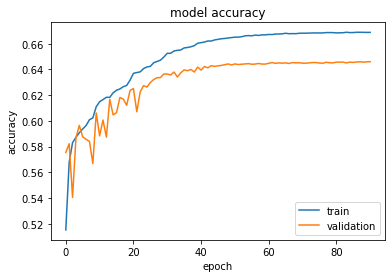

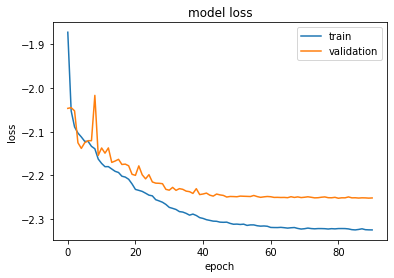

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
test_preds = []
model.load_weights('PATH-TO-BEST-MODEL-WEIGHTS.hdf5')
test_preds = model.predict(test_inputs)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.argmax(test_targets, axis = 1), np.argmax(test_preds, axis = 1))
print(matrix)
acc_class_0 = 100*(matrix[0,0]+(3/4)*matrix[0,1]+(2/4)*matrix[0,2]+(1/4)*matrix[0,3])/np.sum(matrix[0,:])
acc_class_1 = 100*(matrix[1,1]+(3/4)*matrix[1,0]+(3/4)*matrix[1,2]+(2/4)*matrix[1,3]+(1/4)*matrix[1,4])/np.sum(matrix[1,:])
acc_class_2 = 100*(matrix[2,2]+(3/4)*matrix[2,1]+(3/4)*matrix[2,3]+(2/4)*matrix[2,4]+(2/4)*matrix[2,0])/np.sum(matrix[2,:])
acc_class_3 = 100*(matrix[3,3]+(3/4)*matrix[3,4]+(3/4)*matrix[3,2]+(2/4)*matrix[3,1]+(1/4)*matrix[3,0])/np.sum(matrix[3,:])
acc_class_4 = 100*(matrix[4,4]+(3/4)*matrix[4,3]+(2/4)*matrix[4,2]+(1/4)*matrix[4,1])/np.sum(matrix[4,:])
total = (acc_class_0 + acc_class_1 +acc_class_2 +acc_class_3 +acc_class_4)/5
print('Grade 0 Accuracy: %' + str(acc_class_0))
print('Grade 1 Accuracy: %' + str(acc_class_1))
print('Grade 2 Accuracy: %' + str(acc_class_2))
print('Grade 3 Accuracy: %' + str(acc_class_3))
print('Grade 4 Accuracy: %' + str(acc_class_4))
print('Average Accuracy: %' + str(total))

[[   0 3425   15    0    0]
 [   0 2861  535    4    0]
 [   0 1433 1889  152    1]
 [   0   29  236 3013  107]
 [   0    0    0   63 3322]]
Grade 0 Accuracy: %74.89098837209302
Grade 1 Accuracy: %96.00735294117646
Grade 2 Accuracy: %88.58273381294964
Grade 3 Accuracy: %97.03840472673559
Grade 4 Accuracy: %99.53471196454949
Average Accuracy: %91.21083836350086


<AxesSubplot:>

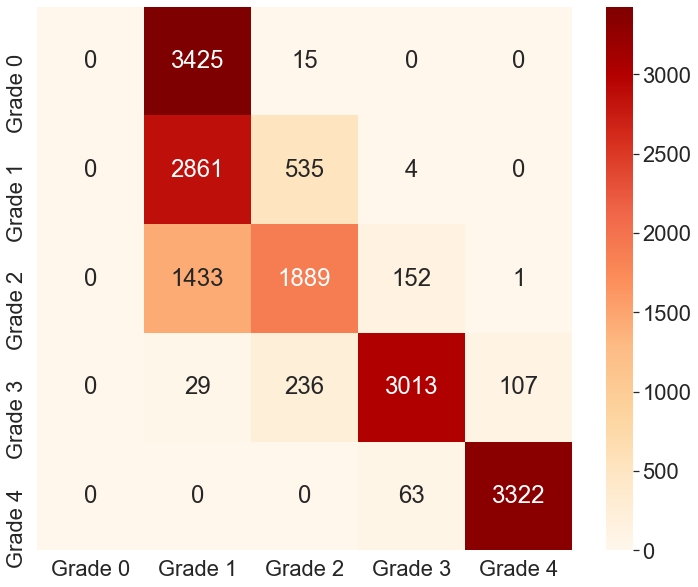

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = matrix
df_cm = pd.DataFrame(array, index = ['Grade 0','Grade 1','Grade 2', 'Grade 3', 'Grade 4'], 
                     columns = ['Grade 0','Grade 1','Grade 2', 'Grade 3', 'Grade 4'])
plt.figure(figsize = (12,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True,cmap="OrRd", fmt=".0f")